## Assignment 1
### Author: Olaf Placha

**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $V=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of exactly two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [52]:
def getFirstNotFull(bucketProbabs, eps = 1e-15) -> int:
    
    """
    Returns index of first bucket that is not full (-1 if all are full)
    """
    
    n = bucketProbabs.shape[1]
    i = 0
    while i < n:
        #check if bucket is not full
        if bucketProbabs[0, i] + bucketProbabs[1, i] + eps < 1 / n:
            return i
        i += 1
    return -1

In [50]:
def getFirstOverflow(bucketProbabs, eps = 1e-15) -> int:
    
    """
    Returns index of first bucket that overflows (-1 if no one overflows)
    """
    
    n = bucketProbabs.shape[1]
    i = 0
    while i < n:
        #check if bucket overflows
        if bucketProbabs[0, i] + bucketProbabs[1, i] - eps > 1 / n:
            return i
        i += 1
    return -1

In [56]:
def produceBuckets(probabilities) -> (np.ndarray, np.ndarray):
    
    """
    Returns buckets' probabilities and labels
    """
    
    #number of buckets
    n = probabilities.shape[0]
    V = 1 / n
    #prepare buckets (each bucket will have up to 2 labels)
    bucketProbabs = np.vstack((probabilities, np.zeros(n)))
    bucketLabels = np.vstack((np.arange(0, n), np.zeros(n)))
    
    #repeat procedure untill all buckets are full <=> getFirstNotFull() returns -1
    while True:
        notFullIdx = getFirstNotFull(bucketProbabs)
        if notFullIdx == -1:
            break
        overflowIdx = getFirstOverflow(bucketProbabs)
        #how much should we transfer
        transfer = V - bucketProbabs[0, notFullIdx]
        #transfering probabilities with labels
        bucketProbabs[1, notFullIdx] = transfer
        bucketLabels[1, notFullIdx] = overflowIdx
        bucketProbabs[0, overflowIdx] -= transfer
        
    return bucketProbabs, bucketLabels

In [93]:
def sampleFromBuckets(bucketProbabs, bucketLabels, k) -> int:
    
    """
    Returns random k number from the distribution described by buckets
    """
    
    n = bucketProbabs.shape[1]
    #get random buckets indices
    randomBuckets = np.random.randint(low = 1, high = n, size = k)
    #get random part of buckets in range [0, 1/n]
    randomParts = np.random.uniform(size = k) / n
    #check what part of bucket was sampled, store the label
    sampled = np.where(bucketProbabs[0, randomBuckets] >= randomParts, 
             bucketLabels[0, randomBuckets], bucketLabels[1, randomBuckets])
    
    return sampled

In [97]:
def sampleUntilCollision(bucketProbabs, bucketLabels, N, k) -> list:
    
    """
    N is the number of experiments, k is the number of examples sampled in one sampling
    Returns list of number of samplings so that the sampled value was already sampled before
    """
    
    result = [0] * N
    #sampling k numbers from buckets
    samples = sampleFromBuckets(bucketProbabs, bucketLabels, k)
    #keeping track of how many values we already used from samples array
    used = 0
    
    for i in range(N):
        
        alreadySampled = set()
        
        while True:
            if used >= k:
                #we have to resample
                samples = sampleFromBuckets(bucketProbabs, bucketLabels, k)
                used = 0
            if samples[used] in alreadySampled:
                result[i] = len(alreadySampled) + 1
                break
            else:
                alreadySampled.add(samples[used])
            used += 1    
    return result

*** Creating buckets with labels ***

In [98]:
#loading data
stats = np.loadtxt("us_births_69_88.csv", delimiter=',', skiprows=1)[:,2]
#probability of birth in each day
p = stats / np.sum(stats)
n = p.shape[0]

#creating buckets
bucketProbabs, bucketLabels = produceBuckets(p)

#sanity check that for every i in [0, n-1] the bucketing did not change the probability of i
for i in range(n):
    assert abs(np.sum(np.where(bucketLabels == i, bucketProbabs, 0)) - p[i]) < 1e-15

*** Finding the best vectorization parameter ***

In [177]:
#maximum number of samples in one sampling
maxInOneSampling = 512
timeTaken = []
for i in range(1, maxInOneSampling, 4):
    t0 = time.time()
    result = sampleUntilCollision(bucketProbabs, bucketLabels, int(1e4), i)
    timeTaken.append(time.time() - t0)

We can see that the more examples we create in one sampling, the faster our algorithm is. But we have to bear in mind that the more examples we create in one sampling, the more data we have to store in the memory in the worst moment

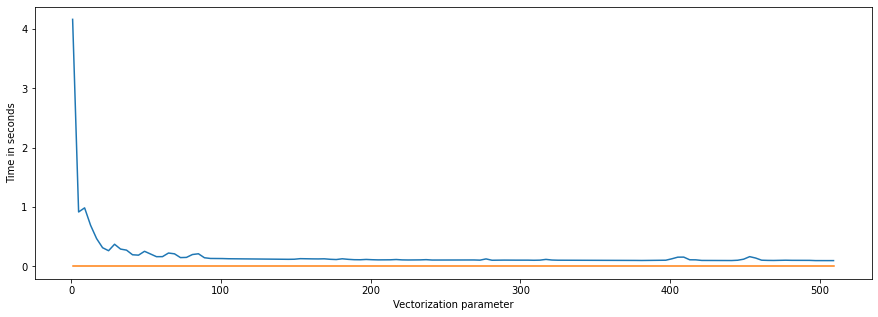

In [178]:
temp = range(1, maxInOneSampling, 4)
plt.figure(figsize=(15,5))
plt.plot(temp, timeTaken)
plt.xlabel("Vectorization parameter")
plt.ylabel("Time in seconds")
plt.plot(temp, [0] * len(temp))
plt.show()

*** Finally using our algorithm ***

Using our bucket sampling algorithm to plot the distribution of random variable $X$, which denotes the number of samplings that you have to do to get 2 people born the same day of the year. Distribution of births across the year is taken from us_births_69_88.csv file

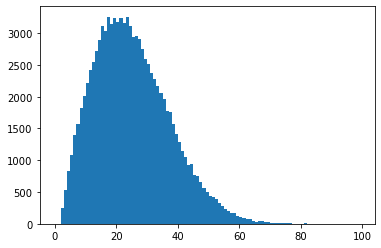

CPU times: user 1.17 s, sys: 4.02 ms, total: 1.18 s
Wall time: 1.18 s


In [189]:
%%time
result = sampleUntilCollision(bucketProbabs, bucketLabels, int(1e5), 512)
plt.hist(result, bins = range(100))
plt.show()